In [1]:
import sys
import os
import numpy as np
import pandas as pd
from empiricaldist import Pmf
from fractions import Fraction
from matplotlib import pyplot as plt
from scipy.stats import binom

from utils import decorate
from utils import set_pyplot_params


In [57]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

In [2]:
set_pyplot_params()

## Diachronic Bayes

There is another way to think of Bayes's theorem: it gives us a way to
update the probability of a hypothesis, $H$, given some body of data, $D$.

This interpretation is "diachronic", which means "related to change over time"; in this case, the probability of the hypotheses changes as we see new data.

Rewriting Bayes's theorem with $H$ and $D$ yields:

$$P(H|D) = \frac{P(H)~P(D|H)}{P(D)}$$

In this interpretation, each term has a name:

-  $P(H)$ is the probability of the hypothesis before we see the data, called the prior probability, or just **prior**.

-  $P(H|D)$ is the probability of the hypothesis after we see the data, called the **posterior**.

-  $P(D|H)$ is the probability of the data under the hypothesis, called the **likelihood**.

-  $P(D)$ is the **total probability of the data**, under any hypothesis.

In [30]:
def update(table):
    """Compute the posterior probabilities."""
    table['unnorm'] = table['prior'] * table['likelihood']
    prob_data = table['unnorm'].sum()
    table['posterior'] = table['unnorm'] / prob_data
    return prob_data

## The Monty Hall Problem

Next we'll use a Bayes table to solve one of the most contentious problems in probability.

The Monty Hall problem is based on a game show called *Let's Make a Deal*. If you are a contestant on the show, here's how the game works:

* The host, Monty Hall, shows you three closed doors -- numbered 1, 2, and 3 -- and tells you that there is a prize behind each door.

* One prize is valuable (traditionally a car), the other two are less valuable (traditionally goats).

* The object of the game is to guess which door has the car. If you guess right, you get to keep the car.

Suppose you pick Door 1. Before opening the door you chose, Monty opens Door 3 and reveals a goat. Then Monty offers you the option to stick with your original choice or switch to the remaining unopened door.

To maximize your chance of winning the car, should you stick with Door 1 or switch to Door 2?

To answer this question, we have to make some assumptions about the behavior of the host:

1.  Monty always opens a door and offers you the option to switch.

2.  He never opens the door you picked or the door with the car.

3.  If you choose the door with the car, he chooses one of the other
    doors at random.

Under these assumptions, you are better off switching. 
If you stick, you win $1/3$ of the time. If you switch, you win $2/3$ of the time.

If you have not encountered this problem before, you might find that
answer surprising. You would not be alone; many people have the strong
intuition that it doesn't matter if you stick or switch. There are two
doors left, they reason, so the chance that the car is behind Door A is 50%. But that is wrong.

To see why, it can help to use a Bayes table. We start with three
hypotheses: the car might be behind Door 1, 2, or 3. According to the
statement of the problem, the prior probability for each door is 1/3.

In [27]:
table3 = pd.DataFrame(index=['Door 1', 'Door 2', 'Door 3'])
table3['prior'] = Fraction(1, 3)
table3

,prior
Door 1,1/3
Door 2,1/3
Door 3,1/3


The data is that Monty opened Door 3 and revealed a goat. So let's
consider the probability of the data under each hypothesis:

* If the car is behind Door 1, Monty chooses Door 2 or 3 at random, so the probability he opens Door 3 is $1/2$.

* If the car is behind Door 2, Monty has to open Door 3, so the probability of the data under this hypothesis is 1.

* If the car is behind Door 3, Monty does not open it, so the probability of the data under this hypothesis is 0.

Here are the likelihoods. 

In [28]:
table3['likelihood'] = Fraction(1, 2), 1, 0
table3

,prior,likelihood
Door 1,1/3,1/2
Door 2,1/3,1
Door 3,1/3,0


In [31]:
update(table3)
table3

,prior,likelihood,unnorm,posterior
Door 1,1/3,1/2,1/6,1/3
Door 2,1/3,1,1/3,2/3
Door 3,1/3,0,0,0


### The Cookie Problem

Here’s the statement of the problem:

Suppose there are two bowls of cookies.

* Bowl 1 contains 30 vanilla cookies and 10 chocolate cookies.

* Bowl 2 contains 20 vanilla cookies and 20 chocolate cookies.

Now suppose you choose one of the bowls at random and, without looking, choose a cookie at random. If the cookie is vanilla, what is the probability that it came from Bowl 1?

What we want is the conditional probability that we chose from Bowl 1 given that we got a vanilla cookie, $P(B_1 | V)$.

But what we get from the statement of the problem is:

* The conditional probability of getting a vanilla cookie, given that we chose from Bowl 1, $P(V | B_1)$ and

* The conditional probability of getting a vanilla cookie, given that we chose from Bowl 2, $P(V | B_2)$.

Bayes's Theorem tells us how they are related:

$$P(B_1|V) = \frac{P(B_1)~P(V|B_1)}{P(V)}$$

The term on the left is what we want. The terms on the right are:

-   $P(B_1)$, the probability that we chose Bowl 1,
    unconditioned by what kind of cookie we got. 
    Since the problem says we chose a bowl at random, 
    we assume $P(B_1) = 1/2$.

-   $P(V|B_1)$, the probability of getting a vanilla cookie
    from Bowl 1, which is 3/4.

-   $P(V)$, the probability of drawing a vanilla cookie from
    either bowl. 

To compute $P(V)$, we can use the law of total probability:

$$P(V) = P(B_1)~P(V|B_1) ~+~ P(B_2)~P(V|B_2)$$

Plugging in the numbers from the statement of the problem, we have

$$P(V) = (1/2)~(3/4) ~+~ (1/2)~(1/2) = 5/8$$

We can also compute this result directly, like this: 

* Since we had an equal chance of choosing either bowl and the bowls contain the same number of cookies, we had the same chance of choosing any cookie. 

* Between the two bowls there are 50 vanilla and 30 chocolate cookies, so $P(V) = 5/8$.

Finally, we can apply Bayes's Theorem to compute the posterior probability of Bowl 1:

$$P(B_1|V) = (1/2)~(3/4)~/~(5/8) = 3/5$$

This example demonstrates one use of Bayes's theorem: it provides a
way to get from $P(B|A)$ to $P(A|B)$. 
This strategy is useful in cases like this where it is easier to compute the terms on the right side than the term on the left.

In [2]:
prior = Pmf.from_seq(['Bowl 1', 'Bowl 2'])
prior

,probs
Bowl 1,0.5
Bowl 2,0.5


In [3]:
likelihood_vanilla = [0.75, 0.5]
posterior = prior * likelihood_vanilla
posterior

,probs
Bowl 1,0.375
Bowl 2,0.250


In [4]:
posterior.normalize()

0.625

In [5]:
posterior

,probs
Bowl 1,0.6
Bowl 2,0.4


In [6]:
posterior('Bowl 1')

0.6

One benefit of using <span style="color:red">Pmf</span> objects is that it is easy to do successive updates with more data. For example, suppose you put the first cookie back (so the contents of the bowls don’t change) and draw again from the same bowl. If the second cookie is also vanilla, we can do a second update like this:

In [7]:
posterior *= likelihood_vanilla
posterior.normalize()
posterior

,probs
Bowl 1,0.692308
Bowl 2,0.307692


Now the posterior probability for Bowl 1 is almost 70%. But suppose we do the same thing again and get a chocolate cookie.

In [9]:
likelihood_chocolate = [0.25, 0.5]

In [10]:
posterior *= likelihood_chocolate
posterior.normalize()
posterior

,probs
Bowl 1,0.529412
Bowl 2,0.470588


## 101 Bowls
Next let’s solve a cookie problem with 101 bowls:

* Bowl 0 contains 0% vanilla cookies,

* Bowl 1 contains 1% vanilla cookies,

* Bowl 2 contains 2% vanilla cookies,

and so on, up to

* Bowl 99 contains 99% vanilla cookies, and

* Bowl 100 contains all vanilla cookies.

As in the previous version, there are only two kinds of cookies, vanilla and chocolate. So Bowl 0 is all chocolate cookies, Bowl 1 is 99% chocolate, and so on.

Suppose we choose a bowl at random, choose a cookie at random, and it turns out to be vanilla. What is the probability that the cookie came from Bowl 𝑥, for each value of 𝑥?

In [12]:
hypos = np.arange(101)

In [14]:
prior = Pmf(1, hypos)
prior.normalize()
prior.head()

,probs
0,0.009901
1,0.009901
2,0.009901


In [16]:
likelihood_vanilla = hypos / 100

In [17]:
posterior1 = prior * likelihood_vanilla
posterior1.normalize()
posterior1.head()

,probs
0,0.000000
1,0.000198
2,0.000396


Text(0, 0.5, 'PMF')

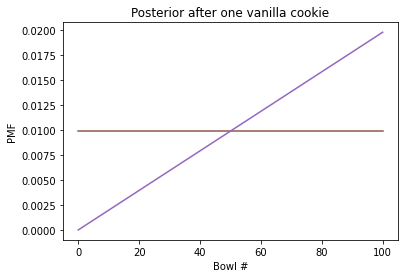

In [34]:
prior.plot(label='prior', color='C5')
posterior1.plot(label='posterior', color='C4')
plt.title('Posterior after one vanilla cookie')
plt.xlabel('Bowl #')
plt.ylabel('PMF')

Now suppose we put the cookie back, draw again from the same bowl, and get another vanilla cookie. Here’s the update after the second cookie:

Now suppose we put the cookie back, draw again from the same bowl, and get another vanilla cookie. Here’s the update after the second cookie:

In [37]:
posterior2 = posterior1 * likelihood_vanilla
posterior2.normalize()

0.6699999999999999

Text(0.5, 1.0, 'Posterior after two vanilla cookies')

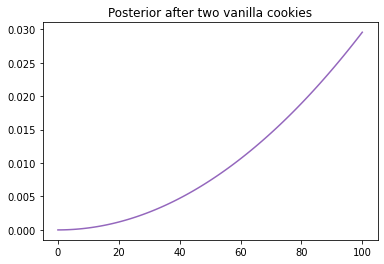

In [38]:
posterior2.plot(label='posterior', color='C4')
plt.title('Posterior after two vanilla cookies')

But suppose we draw again and get a chocolate cookie. Here’s the update:

In [39]:
likelihood_chocolate = 1 - hypos / 100

posterior3 = posterior2 * likelihood_chocolate
posterior3.normalize()

0.2462686567164179

Text(0.5, 1.0, 'Posterior after 2 vanilla, 1 chocolate')

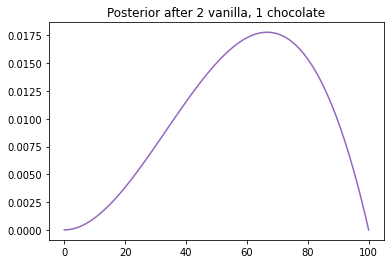

In [40]:
posterior3.plot(label='posterior', color='C4')
plt.title('Posterior after 2 vanilla, 1 chocolate')

Now Bowl 100 has been eliminated because it contains no chocolate cookies.
But the high-numbered bowls are still more likely than the low-numbered bowls, because we have seen more vanilla cookies than chocolate.

In fact, the peak of the posterior distribution is at Bowl 67, which corresponds to the fraction of vanilla cookies in the data we've observed, $2/3$.

The quantity with the highest posterior probability is called the **MAP**, which stands for "maximum a posteori probability", where "a posteori" is unnecessary Latin for "posterior".

To compute the MAP, we can use the `Series` method `idxmax`:

In [41]:
posterior3.idxmax()

67

In [42]:
posterior3.max_prob()

67

As you might suspect, this example isn't really about bowls; it's about estimating proportions.
Imagine that you have one bowl of cookies.
You don't know what fraction of cookies are vanilla, but you think it is equally likely to be any fraction from 0 to 1.
If you draw three cookies and two are vanilla, what proportion of cookies in the bowl do you think are vanilla?

## The Euro Problem

In *Information Theory, Inference, and Learning Algorithms*, David MacKay poses this problem:

"A statistical statement appeared in *The Guardian* on Friday January 4, 2002:

> When spun on edge 250 times, a Belgian one-euro coin came up heads 140 times and tails 110.  \`It looks very suspicious to me,' said Barry Blight, a statistics lecturer at the London School of Economics.  \`If the coin were unbiased, the chance of getting a result as extreme as that would be less than 7%.'

"But [MacKay asks] do these data give evidence that the coin is biased rather than fair?"

To answer that question, we'll proceed in two steps.
First we'll use the binomial distribution to see where that 7% came from; then we'll use Bayes's Theorem to estimate the probability that this coin comes up heads.

$$\binom{n}{k} p^k (1-p)^{n-k}$$



In [3]:
n = 2
p = 0.5
k = 1

binom.pmf(k, n, p)

0.5000000000000002

In [4]:
ks = np.arange(n+1)

ps = binom.pmf(ks, n, p)
ps

array([0.25, 0.5 , 0.25])

In [5]:
pmf_k = Pmf(ps, ks)
pmf_k

,probs
0,0.25
1,0.50
2,0.25


In [6]:
def make_binomial(n, p):
    """Make a binomial Pmf."""
    ks = np.arange(n+1)
    ps = binom.pmf(ks, n, p)
    return Pmf(ps, ks)

In [7]:
pmf_k = make_binomial(n=250, p=0.5)

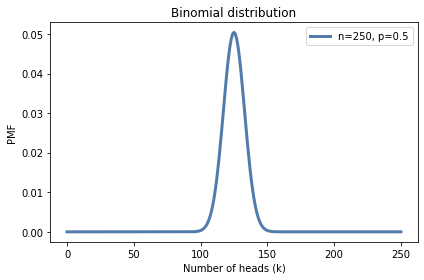

In [8]:
pmf_k.plot(label='n=250, p=0.5')

decorate(xlabel='Number of heads (k)',
         ylabel='PMF',
         title='Binomial distribution')

In [9]:
pmf_k.max_prob()

125

In [10]:
pmf_k[125]

0.0504122131473097

In [11]:
pmf_k[140]

0.008357181724918204

In [12]:
def prob_ge(pmf, threshold):
    """Probability of quantities greater than threshold."""
    ge = (pmf.qs >= threshold)
    total = pmf[ge].sum()
    return total

In [13]:
prob_ge(pmf_k, 140)

0.03321057562002169

In [14]:
pmf_k.prob_ge(140)

0.03321057562002169

The result is about 3.3%, which is less than the quoted 7%.  The reason for the difference is that the statistician includes all outcomes "as extreme as" 140, which includes outcomes less than or equal to 110.

To see where that comes from, recall that the expected number of heads is 125.  If we get 140, we've exceeded that expectation by 15.
And if we get 110, we have come up short by 15.

7% is the sum of both of these "tails", as shown in the following figure.

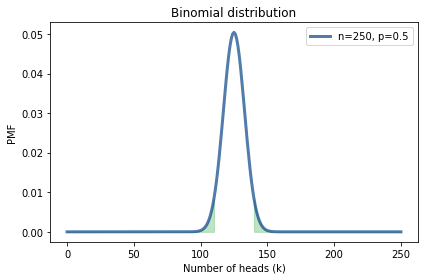

In [22]:
def fill_below(pmf):
    qs = pmf.index
    ps = pmf.values
    plt.fill_between(qs, ps, 0, color='C25', alpha=0.4)

qs = pmf_k.index
fill_below(pmf_k[qs >= 140])
fill_below(pmf_k[qs <= 110])
pmf_k.plot(label='n=250, p=0.5')

decorate(xlabel='Number of heads (k)',
         ylabel='PMF',
         title='Binomial distribution')

In [23]:
pmf_k.prob_le(110)

0.03321057562002169

## The Dice Problem

In the previous chapter we solved the dice problem using a Bayes table.
Here's the statement of the problem:

> Suppose I have a box with a 6-sided die, an 8-sided die, and a 12-sided die.
> I choose one of the dice at random, roll it, and report that the outcome is a 1.
> What is the probability that I chose the 6-sided die?


In [43]:
hypos = [6, 8, 12]

In [44]:
prior = Pmf(1/3, hypos)
prior

,probs
6,0.333333
8,0.333333
12,0.333333


In [45]:
prior.qs

array([ 6,  8, 12])

In [46]:
prior.ps

array([0.33333333, 0.33333333, 0.33333333])

In [47]:
likelihood1 = 1/6, 1/8, 1/12

In [49]:
posterior = prior * likelihood1
posterior.normalize()
posterior

,probs
6,0.444444
8,0.333333
12,0.222222


Now suppose I roll the same die again and get a 7. Here are the likelihoods:

In [50]:
likelihood2 = 0, 1/8, 1/12

In [51]:
posterior *= likelihood2
posterior.normalize()
posterior

,probs
6,0.000000
8,0.692308
12,0.307692


## Updating Dice

In [52]:
def update_dice(pmf, data):
    """Update pmf based on new data."""
    hypos = pmf.qs
    likelihood = 1 / hypos
    impossible = (data > hypos)
    likelihood[impossible] = 0
    pmf *= likelihood
    pmf.normalize()

In [53]:
pmf = prior.copy()
pmf

,probs
6,0.333333
8,0.333333
12,0.333333


In [54]:
update_dice(pmf, 1)
update_dice(pmf, 7)
pmf

,probs
6,0.000000
8,0.692308
12,0.307692
